# Monte Carlo Estimation of Pi
How do we know the value of pi? We have to compute it. One way to compute it is through random sampling. Image a 1x1 square with a cirle enscribed in it. If we randomly place dots in the sqaure, the ratio of the number of dots in the sqaure $N_s$ to the number of dots in the circle $N_c$ will estimate the ratio of the areas of the two shapes $ \frac{N_c}{N_s} = \frac{A_c}{A_s}$. Since $A_s = 1^2 = 1$ and $A_c = \pi \left(\frac{1}{2}\right)^2 = \frac{pi}{4}$, $\pi = \frac{4N_c}{N_s} = \frac{4N_c}{N}$ where $N_s = N$ since the random samples only fill within the square, so every point is within the sqaure.

In [24]:
import random
import time
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

In [25]:
N = 2**15  # total number of samples needs to be power of 2 for fast random number generation
Nc = 0

print("Total number of samples:",N)
for i in range(N):
    # Get random x and y values where bottom left corner of the sqaure is (0,0)
    rand_xval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
    rand_yval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
    # Compute radial distance [remember cirle is centered at (0.5,0.5)]
    rad_dis = np.sqrt((rand_xval-0.5)*(rand_xval-0.5) + (rand_yval-0.5)*(rand_yval-0.5))  # no need to take sqaure root since radius is 1
    if (rad_dis < 0.5):
        Nc += 1
print('pi estimation:',4*Nc/N)


Total number of samples: 32768
pi estimation: 3.1427001953125


In [30]:
# Speed up computation njit speeds up calculation from 39 miliseconds to 280 microseconds for N = 8192
@njit(fastmath=True)
def pi(N):
    Nc = 0
    for i in range(N):
        # Get random x and y values where bottom left corner of the sqaure is (0,0)
        rand_xval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
        rand_yval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
        # Compute radial distance [remember cirle is centered at (0.5,0.5)]
        rad_dis = np.sqrt((rand_xval-0.5)*(rand_xval-0.5) + (rand_yval-0.5)*(rand_yval-0.5))  # no need to take sqaure root since radius is 1
        if (rad_dis < 0.5):
            Nc += 1
    return 4*Nc/N

In [32]:
%timeit pi(2**13)

253 µs ± 4.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [98]:
# See sample size N vs computation time
Ns = np.asarray([2**i for i in range(14,27)])
T = np.zeros(Ns.shape)
pi_ests = np.zeros(Ns.shape)

for i,n in enumerate(Ns):
    start = time.time()
    pi_est = pi(n)
    end = time.time()
    pi_ests[i] = pi_est
    T[i] = end-start

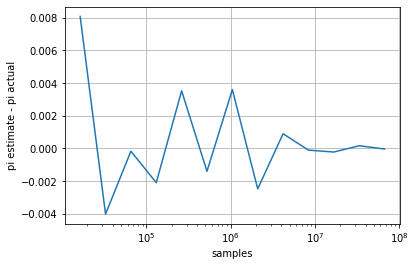

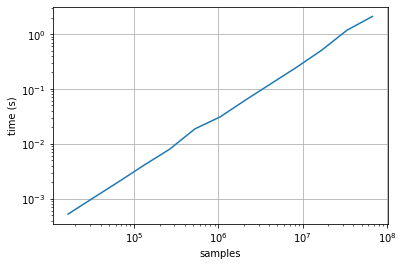

In [104]:
# "Residuals"
plt.plot(Ns,pi_ests-np.pi)
plt.ylabel('pi estimate - pi actual')
plt.xscale('log')
plt.xlabel('samples')
plt.grid(True)
plt.show()

# Samples vs Time
plt.plot(Ns,T)
plt.xscale('log')
plt.xlabel('samples')
plt.yscale('log')
plt.ylabel('time (s)')
plt.grid(True)
plt.show()

### Random Sample Generator: Classical vs Quantum

Can we see performance difference between a classical random number generator and a quantum computer random number generator?